In [1]:
!pip install gensim==4.1.2

In [2]:
import math
from random import shuffle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gensim.models.word2vec import Word2Vec
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor

# Load Data

In [3]:
# Use the unprocessed raw data. both spikes and locations measured at 20ms. 
# One should be able to replicate all rat2192 feat and pos files from these sources
raw_spikes = pd.read_csv("https://drive.google.com/uc?id=1-IuXanc2RZICrzqEG7jTg7f_AN9K9Ufl&export=download",
                         header=None)
raw_loc = pd.read_csv("https://drive.google.com/uc?id=1-XHfaaYkfNeQHYefY4uGX4r1q3AKGbic&export=download", header=None)


In [4]:
NEURONS_LIST = raw_spikes.columns.tolist()
NUM_NEURONS = len(NEURONS_LIST)

In [5]:
raw_loc.columns = ["x", "y"]
combined_data = pd.concat([raw_spikes, raw_loc], axis=1)

combined_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,x,y
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51.638692,50.011963
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,51.620670,50.039728
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51.619204,50.092329
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51.640303,50.105809
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,51.673819,50.116286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54095,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,62.967008,73.292313
54096,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,62.967008,73.292313
54097,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,62.967008,73.292313
54098,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,62.967008,73.292313


# Preprocessing (window length, size and skip)

In [6]:
def get_windows(df_len, window_len=10, window_hop=10, skip=0, midpos=-1, drop_incomplete=False):
  num_windows = math.ceil((df_len - skip) / window_hop)
  answer = []
  for i in range(num_windows):
    start = skip + i * window_hop
    end = min(start + window_len, df_len)

    if drop_incomplete and end-start < window_len:
      print(f"Dropping range {start}-{end}")
      break

    if midpos == -1:
      mid = math.floor((start + end) / 2)
    else:
      mid = start + midpos

    answer.append((start, end, mid))

  return answer


def get_locations(df, window_len=10, window_hop=10, skip=0):
  idx = [False] * len(df)
  for w in get_windows(len(df), window_len, window_hop, skip):
    mid = w[2]
    idx[mid - 1] = True

  return df[idx]


def build_sentences(df, window_len=10, window_hop=10, skip=0, max_empty_words=2, word_ordering="shuffle"):
  """
  builds sentence vectors from spiking data
  window_len: how many spiking timesteps are used for one sentence
  window_hop: how much to slide the window. if window_len==window_hop there is no overlap. if hop<len, there is overlap.
  max_empty_words: how many consecutive empty words ("_") to keep. if 0, they are removed alltogether. if -1, keep all of them
  word_ordering: "shuffle" or "sort". If several neurons spike in one timestep, how to order them. If the same set of neurons spiked, maybe we should have consistent ordering?
  skip: how many timesteps to skip from the beginning. maybe the rat is training at first and we should discard that data?
  """

  sents = []
  for w in get_windows(len(df), window_len, window_hop, skip):
    start, end, mid = w

    # process one sentence
    sent_words = []
    empty_seq_len = 0
    for j in range(start, end):
      row = df.iloc[j]

      if np.sum(row) == 0:
        empty_seq_len += 1

        if max_empty_words == -1 or max_empty_words >= empty_seq_len:
          sent_words.append("_")

      else:
        empty_seq_len = 0

        one_spike = row[row == 1].index.tolist()
        two_spikes = row[row == 2].index.tolist()
        three_spikes = row[row == 3].index.tolist()
        four_spikes = row[row == 4].index.tolist()
        word = 4 * four_spikes + 3 * three_spikes + 2 * two_spikes + one_spike

        if word_ordering == "shuffle":
          shuffle(word)
        else:
          word.sort()

        sent_words += word

    if len(sent_words) == 0:
      sent_words = ["_"]

    sents.append(sent_words)

  return sents


def get_original_features(df, window_len, window_hop, skip=0):
  """
  calculates the features and positions (almost) identical in the repo
  e.g. get_original_features(df, 10, 10) yields the contents of:
    R2192_1x200_at5_step200_bin100-RAW_feat.dat
    R2192_1x200_at5_step200_bin100-RAW_pos.dat

  In filenames, window and step are given in ms (while location in timestep offsets)
  In this function, all are given in timestep offsets (divide milliseconds by 20)
  Mapping between the arguments and filenames:
  R2192_1x200_at5_step200_bin100: 10,10
  R2192_1x400_at10_step200_bin100: 20,10
  ...
  R2192_1x4000_at100_step200_bin100: 200,10
  """
  windows = get_windows(len(df), window_len, window_hop, skip, drop_incomplete=True)
  out = np.empty((len(windows), df.shape[1]))
  for i,w in enumerate(windows):
    start, end, mid = w
    slice = df[start:end].sum().values
    slice[-2:] = df.iloc[mid][["x","y"]].values
    out[i,:] = slice

  return out


def split_df(df, train_ratio):
  idx = math.floor(len(df) * train_ratio)
  return df[:idx], df[idx:]

# Word2Vec


In [7]:
def train_word2vec(sents, vector_len=250, train_size=0.8, window_size=5, sg=0, shrink_windows=True, alpha=0.025,
                   seed=42):
  model = Word2Vec(min_count=1, vector_size=vector_len, window=window_size, max_vocab_size=None, max_final_vocab=None,
                   sg=sg, compute_loss=True, workers=6, shrink_windows=shrink_windows, alpha=alpha, seed=seed)
  # Build vocab from full dataset.
  # In some cases, the word might not have ended up in train set. Then the model would throw an error.
  model.build_vocab(sents)

  train_test_boundary = math.floor(len(sents) * train_size)
  train_sents = sents[:train_test_boundary]
  model.train(corpus_iterable=train_sents, total_examples=len(train_sents), epochs=20, compute_loss=True)
  return model

# Similar Neurons

Spiking overview of all neurons

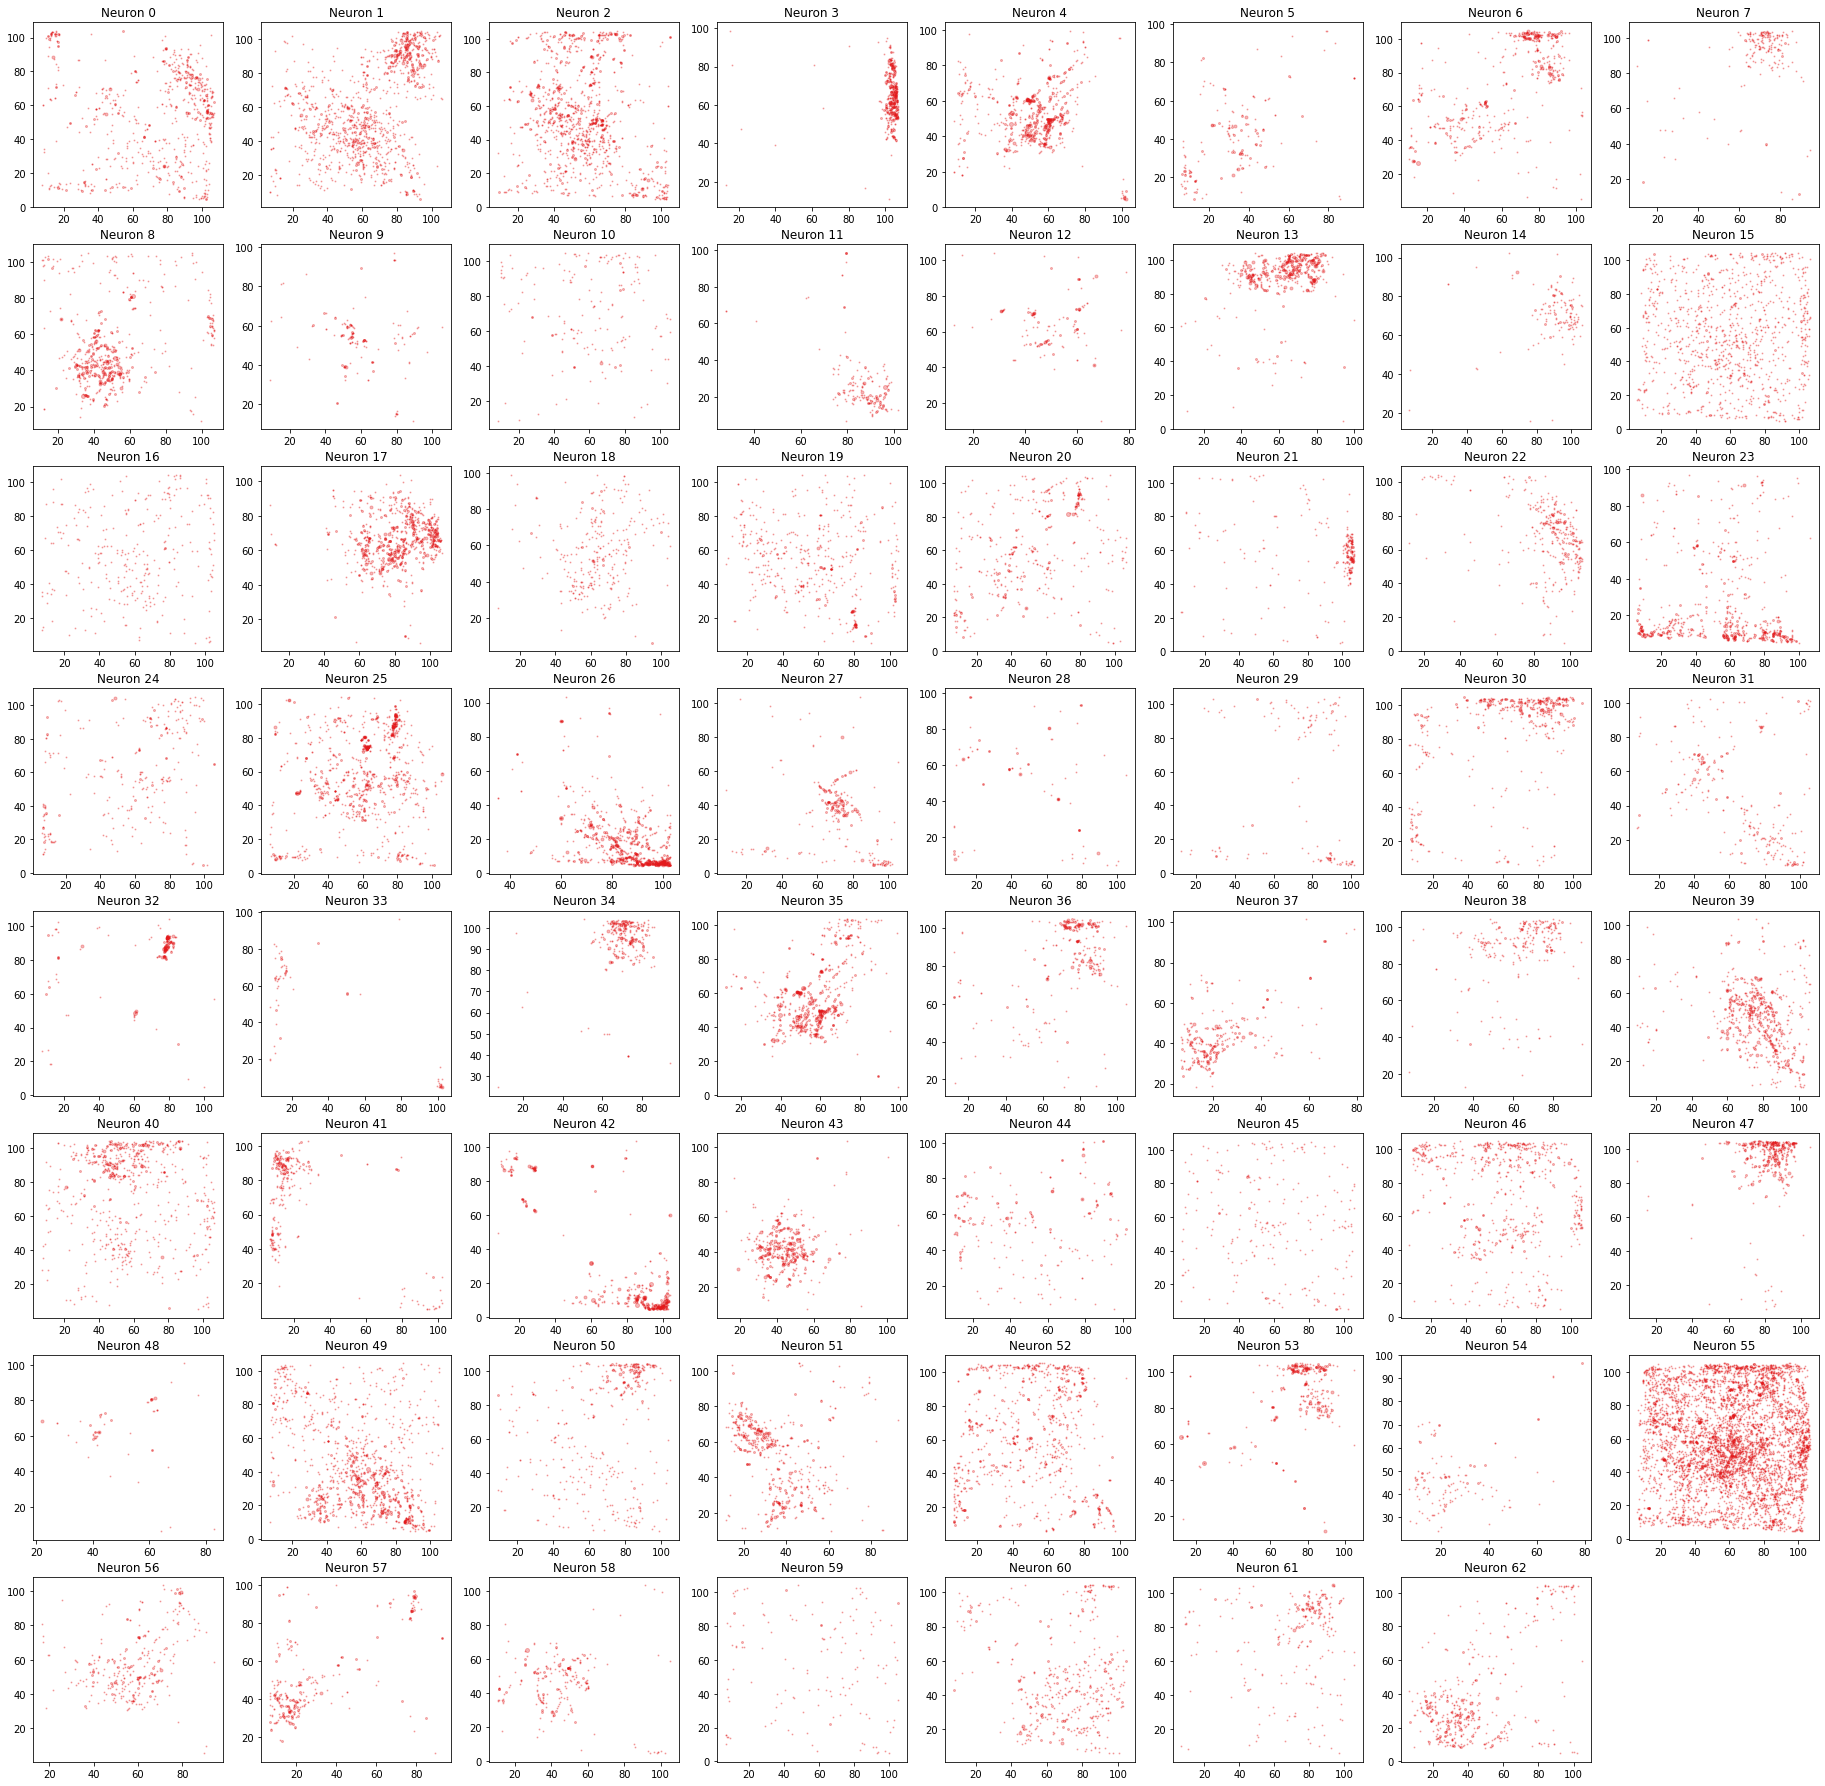

In [8]:
def print_all_neurons(spiking_and_loc_df):
  edge_size = math.ceil(math.sqrt(NUM_NEURONS))  # 63 neurons -> 8x8
  plt.rcParams['figure.figsize'] = (edge_size * 4, edge_size * 4)

  for neuron in range(NUM_NEURONS):
    plt.subplot(edge_size, edge_size, neuron + 1)
    plt.title(f"Neuron {neuron}")
    non_empty = spiking_and_loc_df[spiking_and_loc_df[neuron] > 0]
    for _, row in non_empty.iterrows():
      x0, y0 = row[["x", "y"]]
      num_spikes = row[neuron]
      plt.plot([x0], [y0], '.', markersize=num_spikes * 2, color="#e31a1c", alpha=0.3)


print_all_neurons(combined_data)

Word2Vec Similarity

In [9]:
sents = build_sentences(raw_spikes)
word2vec_model = train_word2vec(sents)

In [10]:
def build_similarity_dfs_for_top_n_neurons(wordvecs, top_n):
  similar_neurons = []
  similarities = []
  for neuron in range(NUM_NEURONS):
    sims = wordvecs.wv.most_similar([neuron], topn=top_n)
    similar_neurons.append([neuron_id for neuron_id, similarity in sims])
    similarities.append([similarity for neuron_id, similarity in sims])

  similar_neurons_df = pd.DataFrame(data=similar_neurons).T
  similarity_scores_df = pd.DataFrame(data=similarities).T

  return similar_neurons_df, similarity_scores_df

In [11]:
def plot_most_similar(neuron_id, wordvecs, spiking_and_loc_df, top_n=5):
  similar_df, similarities_df = build_similarity_dfs_for_top_n_neurons(wordvecs, top_n)

  neurons_list = [neuron_id] + similar_df[neuron_id].tolist()

  rows, cols = 1, len(neurons_list)
  plt.rcParams['figure.figsize'] = (cols * 4, rows * 4)

  for i, neuron in enumerate(neurons_list):
    plt.subplot(rows, cols, i + 1)

    if i == 0:
      plt.title(f"neuron {neuron}")
    else:
      plt.title(f"SIM {i}: neuron {neuron} ({round(similarities_df.iloc[i - 1, neuron_id], 3)})")

    if neuron != "_":
      non_empty = spiking_and_loc_df[spiking_and_loc_df[neuron] > 0]
      for _, row in non_empty.iterrows():
        x0, y0 = row[["x", "y"]]
        num_spikes = row[neuron]
        plt.plot([x0], [y0], '.', markersize=num_spikes * 2, color="#e31a1c", alpha=0.3)


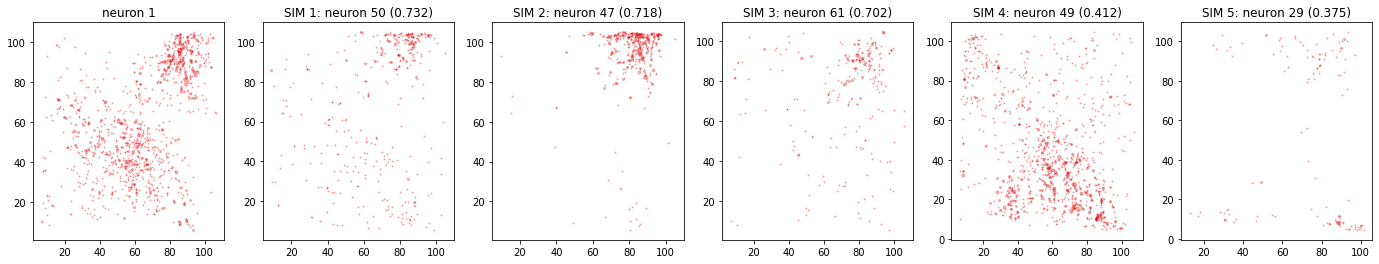

In [12]:
plot_most_similar(1, word2vec_model, combined_data)

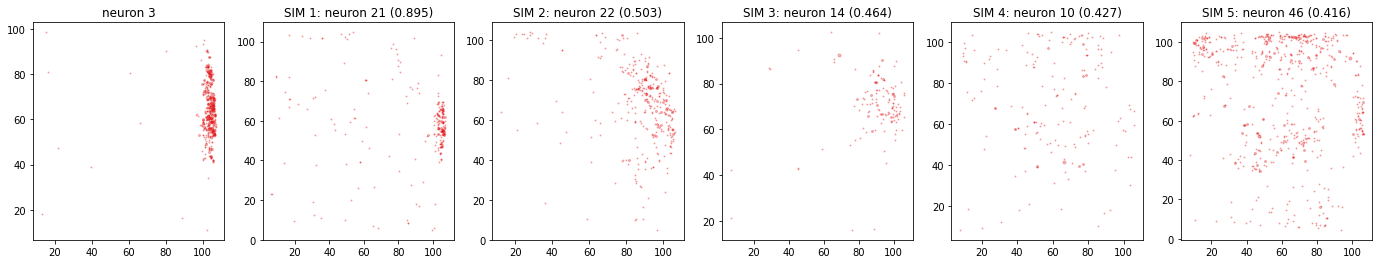

In [13]:
plot_most_similar(3, word2vec_model, combined_data)

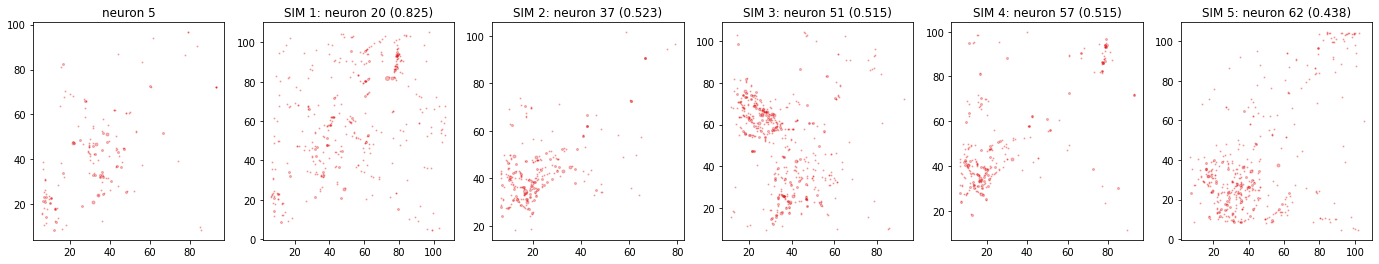

In [14]:
plot_most_similar(5, word2vec_model, combined_data)

# Regression

In [15]:
def build_features(word2vec_model, sents, method="mean"):
  features = []
  for sent in sents:
    vecs = np.array([word2vec_model.wv[word] for word in sent])
    if method == "mean":
      features.append(np.mean(vecs, axis=0))
    else:
      # concatenate instead
      features.append(vecs.flatten())

  if method != "mean":
    # right-pad every row with zeros so that every vector has the same length
    maxlen = max([len(row) for row in features])
    features = [np.append(row, [0] * (maxlen - len(row))) for row in features]
    features = np.array(features)
  return features


def split_df(df, train_ratio):
  idx = math.floor(len(df) * train_ratio)
  return df[:idx], df[idx:]


#wordVecs, sents, locs,
#sent_vecs = build_features(wordVecs, sents, method = "mean")
def benchmark(model: MultiOutputRegressor, X, y, train_ratio=0.8):
  if len(X) != len(y):
    raise Exception(f"different number of sentences and locations: {len(X)} != {len(y)}")

  train_x, test_x = split_df(X, train_ratio)
  train_x = pd.DataFrame(data=train_x)
  test_x = pd.DataFrame(data=test_x)

  train_y, test_y = split_df(locations, train_ratio)

  model = model.fit(train_x, train_y)
  preds = model.predict(test_x)
  preds = preds.T

  dists = np.sqrt((test_y['x'] - preds[0]) ** 2 + (test_y['y'] - preds[1]) ** 2)
  avg_dist = np.mean(dists)

  return avg_dist



## Test with default settings

In [16]:
sents = build_sentences(raw_spikes, window_len=10, window_hop=10, skip=0)
locations = get_locations(raw_loc, window_len=10, window_hop=10, skip=0)

word2vec_model = train_word2vec(sents)
input_features = build_features(word2vec_model, sents, method="mean")

KeyboardInterrupt: ignored

In [ ]:
print("Linear regression")

benchmark(
  MultiOutputRegressor(LinearRegression()),
  X=input_features,
  y=locations
)

In [ ]:
print("Random Forest")

benchmark(
  MultiOutputRegressor(RandomForestRegressor(min_samples_leaf=3)),
  X=input_features,
  y=locations
)

## Test with ordered words


In [ ]:
# sents = build_sentences(raw_spikes, window_len=10, window_hop=10, skip=0, word_ordering="sort")
# locations = get_locations(raw_loc, window_len=10, window_hop=10, skip=0)

# word2vec_model = train_word2vec(sents)
# input_features = build_features(word2vec_model, sents, method="mean")

In [ ]:
# benchmark(
#   MultiOutputRegressor(LinearRegression()),
#   X=input_features,
#   y=locations
# )

## Test with all empty words removed


In [ ]:
# sents = build_sentences(raw_spikes, window_len=10, window_hop=10, skip=0, max_empty_words=0)
# locations = get_locations(raw_loc, window_len=10, window_hop=10, skip=0)

# word2vec_model = train_word2vec(sents)
# input_features = build_features(word2vec_model, sents, method="mean")

In [ ]:
# benchmark(
#   MultiOutputRegressor(LinearRegression()),
#   X=input_features,
#   y=locations
# )

### Test with concatenating words instead of averaging

In [ ]:
# input_features = build_features(word2vec_model, sents, method="concat")

In [ ]:
# benchmark(
#     MultiOutputRegressor(LinearRegression()),
#     X = input_features,
#     y = locations
# )


### Test after doing some hyperopt search

In [ ]:
sents = build_sentences(raw_spikes, window_len=150, window_hop=20, skip=0, max_empty_words=9, word_ordering='sort')
locations = get_locations(raw_loc, window_len=150, window_hop=20, skip=0)
word2vec_model = train_word2vec(sents, vector_len=450, window_size=15, sg=0, shrink_windows=True, alpha=0.036)
input_features = build_features(word2vec_model, sents, method="mean")

print("Linear Regression")
benchmark(
  MultiOutputRegressor(LinearRegression()),
  X=input_features,
  y=locations
)

In [ ]:
print("Random Forest")

benchmark(
  MultiOutputRegressor(RandomForestRegressor(min_samples_leaf=3)),
  X=input_features,
  y=locations
)

# Neural Network

In [17]:
def sliding_window(X, y, seqlen):
    # X - matrix where each row corresponds to a spike count vector of length nr_of_neurons
    # y - rat positions at the center of those spike count windows
    # seqlen - length of sequences we want to get out of this function

    Xs = []
    for i in range(seqlen): #0...99        
        #100-99-1 >0
        if seqlen - i - 1 > 0: #not the last piece
            # take slices from 0 to -99, 1 to -98, ...,  98 to -1.
            Xs.append(X[i:-(seqlen - i - 1), np.newaxis, ...])
        else:  # cannot ask X[99:-0], so special case goes here
            print("last piece to add")
            Xs.append(X[i:, np.newaxis, ...])

    # we have seqlen(=100) slices each shifted in time. join them to get sequences of len 100
    X = np.concatenate(Xs, axis=1)
    y = y[seqlen - 1:]  # the positions are taken at the last timestep (from 99 to end)
    print(f"After sliding window: {(X.shape, y.shape)}")

    return X, y

In [61]:
from keras.models import Model
from keras.losses import mean_squared_error
from keras.layers import Input, Dense, Activation, Dropout
from keras.layers import SimpleRNN, LSTM, GRU
import keras
import tensorflow


def createLSTM(seqlen, num_features, hidden_nodes=1024, dropout_ratio=0.5):
    num_outputs = 2

    x = keras.layers.Input(shape=(seqlen, num_features), name="Input")
    h = x

    # first LSTM layer with dropout
    h = keras.layers.LSTM(
      hidden_nodes, input_shape=(seqlen, num_features), return_sequences=True, name="firstLstmBlock"
    )(h)
    h = keras.layers.Dropout(dropout_ratio, name="firstLstmDropout")(h)

    # second LSTM layer with dropout
    h = keras.layers.LSTM(hidden_nodes, name="secondLstmBlock")(h)
    h = keras.layers.Dropout(dropout_ratio, name="secondLstmDropout")(h)

    # finally, add dense layer which acts as output layer
    y = keras.layers.Dense(num_outputs, name="Output")(h)

    model = keras.models.Model(inputs=x, outputs=y, name="RatLSTM")
    model.compile(loss=keras.losses.mean_squared_error, optimizer="rmsprop")

    return model

def get_early_stopping_config(patience=0):
  return keras.callbacks.EarlyStopping(patience=patience, verbose=1)

def get_lr_config(lr=0.001, lr_factor=0.1, lr_epochs=None):
  def lr_scheduler(epoch):
    new_lr = lr * lr_factor ** int(epoch / lr_epochs)
    print(f"Epoch {epoch}: learning rate {new_lr}")
    return new_lr
  return keras.callbacks.LearningRateScheduler(lr_scheduler)

def get_savepoints_config(filepath, save_best_model_only=False):
  return keras.callbacks.ModelCheckpoint(filepath=filepath, verbose=1, save_best_model_only=save_best_model_only)


def create_ff_network(num_features, hidden_nodes=1024, dropout_ratio=0.5):    
  num_outputs = 2

  x = keras.layers.Input(shape=num_features, name="Input")
  h = x

  
  h = keras.layers.Dense(hidden_nodes)(h)
  h = keras.layers.Dropout(dropout_ratio)(h)

  h = keras.layers.Dense(hidden_nodes)(h)
  h = keras.layers.Dropout(dropout_ratio)(h)

  h = keras.layers.Dense(hidden_nodes)(h)
  h = keras.layers.Dropout(dropout_ratio)(h)


  # finally, add dense layer which acts as output layer
  y = keras.layers.Dense(num_outputs, name="Output")(h)

  model = keras.models.Model(inputs=x, outputs=y, name="RatFF")
  lr_schedule = tensorflow.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.9)  
  opt = tensorflow.keras.optimizers.Adam(learning_rate=lr_schedule)
  model.compile(loss=keras.losses.mean_squared_error, optimizer=opt)

  return model


def split_ndarray(df, train_ratio):
  idx = math.floor(len(df) * train_ratio)
  out = df[:idx], df[idx:]
  return out



In [19]:
sents = build_sentences(raw_spikes, window_len=150, window_hop=20, skip=0, max_empty_words=9, word_ordering='shuffle')
locations = get_locations(raw_loc, window_len=150, window_hop=20, skip=0)
word2vec_model = train_word2vec(sents, vector_len=450, window_size=15, sg=0, shrink_windows=True, alpha=0.036)
input_features = build_features(word2vec_model, sents, method="mean")

In [66]:
def test_lstm_original_paper(df, seqlen=100, window_size=10, hop=10):
  
  orig_data = get_original_features(df, seqlen, window_size)
  orig_train, orig_test = split_df(orig_data, 0.8)


  train_feats = orig_train[:,:-2]
  train_pos = orig_train[:,-2:]
  train_X, train_y = sliding_window(train_feats, train_pos, seqlen)

  test_feats = orig_test[:,:-2]
  test_pos =   orig_test[:,-2:]
  test_X, test_y = sliding_window(test_feats, test_pos, seqlen)

  print(train_X.shape)
  print(train_y.shape)
  print(test_X.shape)
  print(test_y.shape)
  
  model = createLSTM(seqlen=seqlen, num_features=train_X.shape[2])
  print(model.summary())
  model.fit(train_X, train_y, batch_size=64, epochs=50, validation_data=(test_X, test_y), shuffle=False)
  return model


test_lstm_original_paper(combined_data, window_size=70)

Dropping range 54040-54100
last piece to add
After sliding window: ((518, 100, 63), (518, 2))
last piece to add
After sliding window: ((56, 100, 63), (56, 2))
(518, 100, 63)
(518, 2)
(56, 100, 63)
(56, 2)
Model: "RatLSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 100, 63)]         0         
                                                                 
 firstLstmBlock (LSTM)       (None, 100, 1024)         4456448   
                                                                 
 firstLstmDropout (Dropout)  (None, 100, 1024)         0         
                                                                 
 secondLstmBlock (LSTM)      (None, 1024)              8392704   
                                                                 
 secondLstmDropout (Dropout)  (None, 1024)             0         
                                                    

In [67]:
sents = build_sentences(raw_spikes, window_len=150, window_hop=20, skip=0, max_empty_words=9, word_ordering='shuffle')
locations = get_locations(raw_loc, window_len=150, window_hop=20, skip=0)
word2vec_model = train_word2vec(sents, vector_len=450, window_size=15, sg=0, shrink_windows=True, alpha=0.036)
input_features = build_features(word2vec_model, sents, method="mean")

In [68]:
def test_lstm_nlp(input_features, locations, seqlen=100, train_ratio=0.8):
  input_features = np.array(input_features)
  train_feats, test_feats = split_ndarray(input_features, train_ratio)
  train_y, test_y = split_df(locations, train_ratio)

  train_X, train_y = sliding_window(train_feats, train_y, 100)
  test_X, test_y = sliding_window(test_feats, test_y, 100)

  model = createLSTM(seqlen=seqlen, num_features=train_X.shape[2])
  print(model.summary())
  model.fit(train_X, train_y, batch_size=64, epochs=50, validation_data=(test_X, test_y), shuffle=False)


test_lstm_nlp(input_features, locations)

last piece to add
After sliding window: ((2065, 100, 450), (2065, 2))
last piece to add
After sliding window: ((442, 100, 450), (442, 2))
Model: "RatLSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 100, 450)]        0         
                                                                 
 firstLstmBlock (LSTM)       (None, 100, 1024)         6041600   
                                                                 
 firstLstmDropout (Dropout)  (None, 100, 1024)         0         
                                                                 
 secondLstmBlock (LSTM)      (None, 1024)              8392704   
                                                                 
 secondLstmDropout (Dropout)  (None, 1024)             0         
                                                                 
 Output (Dense)              (None, 2)               

In [69]:
def test_ff_model(input_features, locations, train_ratio=0.8):
  input_features = np.array(input_features)
  train_X, test_X = split_df(input_features, train_ratio)
  train_y, test_y = split_df(locations, train_ratio)

  model = create_ff_network(num_features = train_X.shape[1])
  print(model.summary())
  model.fit(train_X, train_y, batch_size=64, epochs=250, validation_data=(test_X, test_y), shuffle=False)


test_ff_model(input_features, locations)

Model: "RatFF"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 450)]             0         
                                                                 
 dense_31 (Dense)            (None, 1024)              461824    
                                                                 
 dropout_31 (Dropout)        (None, 1024)              0         
                                                                 
 dense_32 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout_32 (Dropout)        (None, 1024)              0         
                                                                 
 dense_33 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout_33 (Dropout)        (None, 1024)              0     